In [ ]:
# Crop_Yield_Predictor_Final_Cleaned.ipynb

# 🧪 1. Setup & Data Loading
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare updated dataset with manually mapped rainfall
df = pd.read_csv("Cleaned_Crop_Yield_For_Modeling.csv")
df = df[df["Crop"] != "Sugarcane"]  # Remove outlier crop

In [ ]:
# 🧼 2. Feature Engineering
# Create efficiency metric
df["Efficiency (tonnes/ha)"] = df["Production (metric tonnes)"] / df["Area (ha)"]
df["Fertilizer per ha"] = df["Fertilizer Used (kg)"] / df["Area (ha)"]
df["Fertilizer Used (tonnes)"] = df["Fertilizer Used (kg)"] / 1000
df["Pesticide Used (tonnes)"] = df["Pesticide Used (kg)"] / 1000
df["Pesticide per ha"] = df["Pesticide Used (kg)"] / df["Area (ha)"]
df["Pesticide per ha (tonnes)"] = (df["Pesticide Used (kg)"] / 1000) / df["Area (ha)"]

# Top 10 crops by frequency
top_10_crops = df["Crop"].value_counts().nlargest(10).index.tolist()
df = df[df["Crop"].isin(top_10_crops)]
top_10_states = df["State"].value_counts().nlargest(10).index.tolist()
df_top_states = df[df["State"].isin(top_10_states)]
# Feature Engineering
df["Pesticide Used (tonnes)"] = df["Pesticide Used (kg)"] / 1000
df["Pesticide per ha"] = df["Pesticide Used (tonnes)"] / df["Area (ha)"]

# Filter to top 10 states
top_states = df["State"].value_counts().nlargest(10).index.tolist()
df_top_states = df[df["State"].isin(top_states)]

In [ ]:
print(df_top_states.columns.tolist())

['Crop', 'Crop_Year', 'Season', 'State', 'Area (ha)', 'Production (metric tonnes)', 'Fertilizer Used (kg)', 'Pesticide Used (kg)', 'Yield (tonnes/ha)', 'Fertilizer_per_Ha', 'Monsoon_Rainfall', 'Annual_Rainfall', 'Efficiency (tonnes/ha)', 'Fertilizer per ha', 'Fertilizer Used (tonnes)', 'Pesticide Used (tonnes)', 'Pesticide per ha', 'Pesticide per ha (tonnes)']


<ipython-input-4-f46722639d36>:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


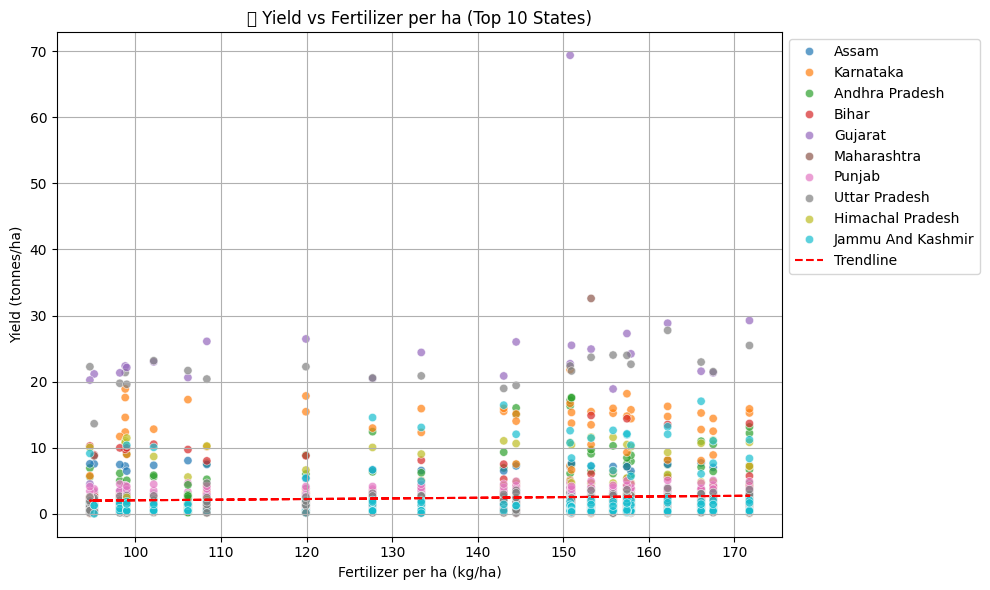

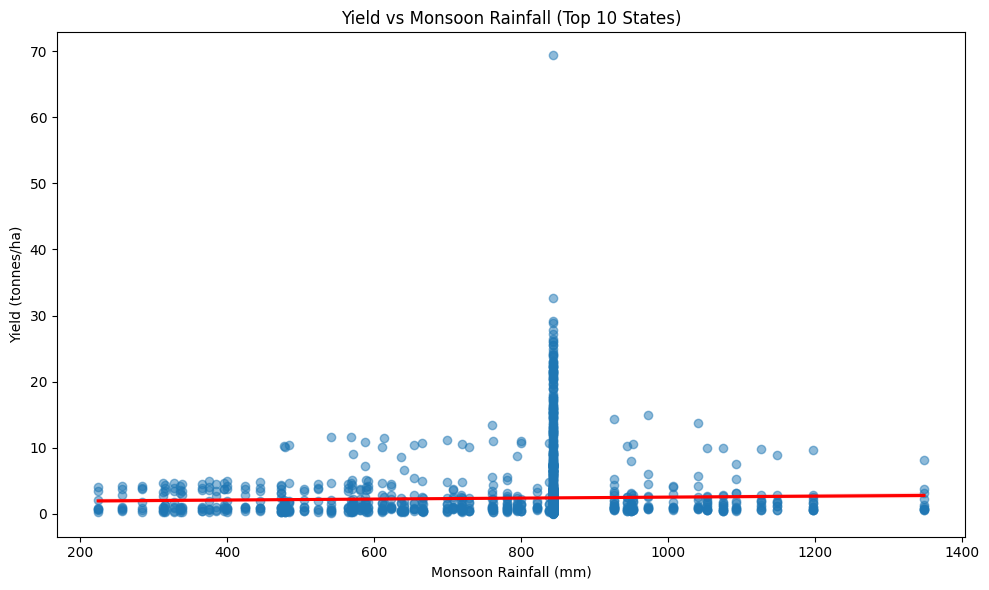

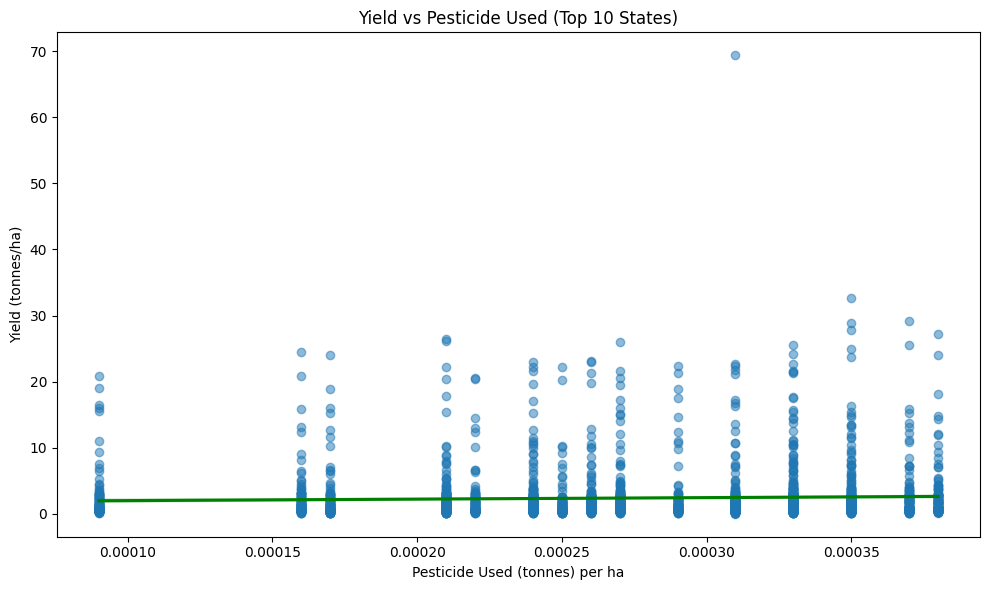

In [ ]:
# 📊 3. Visualizations (Feature Relationships)
# Recalculate using the correct fertilizer column
df["Fertilizer per ha"] = df["Fertilizer Used (kg)"] / df["Area (ha)"]

# Filter for top 10 states
df_top_states = df[df["State"].isin(top_10_states)]

# Plotting with updated data
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top_states,
    x="Fertilizer per ha",
    y="Yield (tonnes/ha)",
    hue="State",
    alpha=0.7
)

# Add trendline
z = np.polyfit(df_top_states["Fertilizer per ha"], df_top_states["Yield (tonnes/ha)"], 1)
p = np.poly1d(z)
plt.plot(df_top_states["Fertilizer per ha"], p(df_top_states["Fertilizer per ha"]), "r--", label="Trendline")

plt.title("📈 Yield vs Fertilizer per ha (Top 10 States)")
plt.xlabel("Fertilizer per ha (kg/ha)")
plt.ylabel("Yield (tonnes/ha)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

#yield vs rainfall during monsoon season
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_top_states,
    x="Monsoon_Rainfall",
    y="Yield (tonnes/ha)",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
plt.title("Yield vs Monsoon Rainfall (Top 10 States)")
plt.xlabel("Monsoon Rainfall (mm)")
plt.ylabel("Yield (tonnes/ha)")
plt.tight_layout()
plt.show()

#yield vs pesticide use
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_top_states,
    x="Pesticide per ha",
    y="Yield (tonnes/ha)",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "green"}
)
plt.title("Yield vs Pesticide Used (Top 10 States)")
plt.xlabel("Pesticide Used (tonnes) per ha")
plt.ylabel("Yield (tonnes/ha)")
plt.tight_layout()
plt.show()


In [ ]:
# 📈 4. Model Training (XGBoost)
# For those unfamiliar with machine learning: here we use a model called XGBoost, which is good at identifying complex patterns in data. We're training it to learn the relationship between features (like crop type, season, fertilizer use, etc.) and the target value — crop yield in tonnes per hectare.

# Once trained, the model can estimate what the yield might be under similar conditions in the future, helping farmers or agri-tech companies make informed decisions.

# The performance of the model is evaluated using:
# - MAE (Mean Absolute Error): the average difference between predicted and actual values. Lower is better.
# - RMSE (Root Mean Squared Error): gives more weight to large errors.
# - R² Score: shows how much of the yield variation the model can explain (1.0 is perfect).

X = df.drop(columns=["Yield (tonnes/ha)"])
y = df["Yield (tonnes/ha)"]

# One-hot encode categoricals
X = pd.get_dummies(X, columns=["Crop", "Season", "State"], drop_first=True)

# Split
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(df_train, y_train)
y_pred = model.predict(df_test)

In [ ]:
# 📏 5. Evaluation
mae = mean_absolute_error(y_test, y_pred)
# Calculate RMSE without the 'squared' argument, then take the square root
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 MAE: {mae:.2f}")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.4f}")

📉 MAE: 0.16
📉 RMSE: 0.41
📈 R² Score: 0.9863


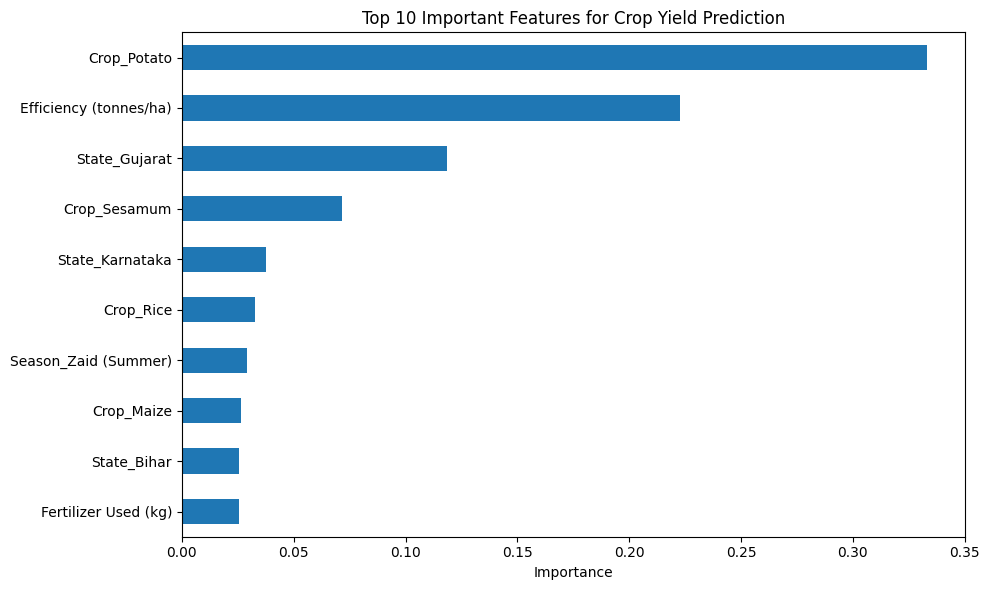

In [ ]:
# 🔍 6. Feature Importances
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind="barh")
plt.title("Top 10 Important Features for Crop Yield Prediction")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
print(df_filtered["Crop_Year"].value_counts().sort_index())

Crop_Year
1997    1
1998    1
1999    1
2000    1
2001    1
2002    1
2003    1
2004    1
2005    1
2006    1
2007    1
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    1
2016    1
2017    1
2018    1
2019    1
Name: count, dtype: int64


In [ ]:
# 🎯 Predict Yield for a Specific Crop/State in a Specific Year

target_crop = "Rice"
target_state = "Punjab"
target_year = 2019  # last year in dataset

df_filtered = df[(df["Crop"] == target_crop) & (df["State"] == target_state)]

# Check that there's data
print("Years available:", df_filtered["Crop_Year"].unique())

# Split data
train_df = df_filtered[df_filtered["Crop_Year"] < target_year]
test_df = df_filtered[df_filtered["Crop_Year"] == target_year]

features = ["Annual_Rainfall", "Fertilizer Used (kg)", "Pesticide Used (kg)"]
target = "Yield (tonnes/ha)"

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Check again just to be safe
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# Train and evaluate
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Actual Yield:", y_test.values)
print("Predicted Yield:", y_pred)
print("MAE:", mean_absolute_error(y_test, y_pred))

from math import sqrt
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)))

print("R²:", r2_score(y_test, y_pred))

Years available: [1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019]
Train size: 22, Test size: 1
Actual Yield: [3.93090909]
Predicted Yield: [3.9924383]
MAE: 0.061529225345214655
RMSE: 0.061529225345214655
R²: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


    Year    Actual  Predicted       MAE      RMSE
0   1998  3.099412   3.476470  0.377059  0.377059
1   1999  3.332353   3.100295  0.232058  0.232058
2   2000  3.501765   3.332331  0.169434  0.169434
3   2001  3.517059   3.500800  0.016259  0.016259
4   2002  3.438824   3.342970  0.095854  0.095854
5   2003  3.678235   3.504038  0.174197  0.174197
6   2004  3.788824   3.589426  0.199398  0.199398
7   2005  3.820588   3.777916  0.042672  0.042672
8   2006  3.750000   3.819497  0.069497  0.069497
9   2007  3.968000   3.819461  0.148539  0.148539
10  2008  3.985500   3.906571  0.078929  0.078929
11  2009  3.977500   3.967973  0.009527  0.009527
12  2010  3.834000   3.536448  0.297552  0.297552
13  2011  3.749500   3.577619  0.171881  0.171881
14  2012  3.923636   3.797698  0.125938  0.125938
15  2013  3.834091   3.834843  0.000752  0.000752
16  2014  3.728182   3.913198  0.185017  0.185017
17  2015  3.923182   3.730890  0.192292  0.192292
18  2016  4.066818   3.922234  0.144584  0.144584


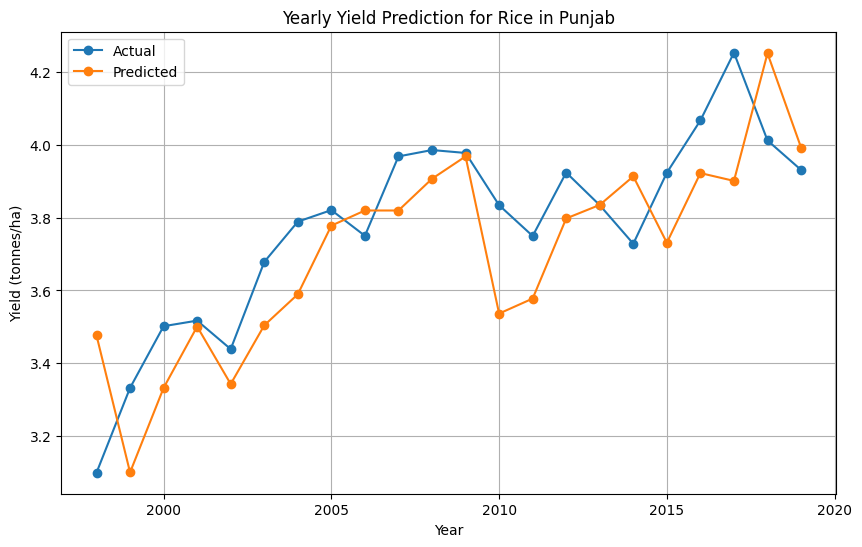

In [ ]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

target_crop = "Rice"
target_state = "Punjab"
df_filtered = df[(df["Crop"] == target_crop) & (df["State"] == target_state)]

results = []

for year in range(1998, 2020):  # Start from 1998 so we have at least one year of training
    train_df = df_filtered[df_filtered["Crop_Year"] < year]
    test_df = df_filtered[df_filtered["Crop_Year"] == year]

    if len(test_df) == 0 or len(train_df) == 0:
        continue  # skip if we can't split properly

    features = ["Annual_Rainfall", "Fertilizer Used (kg)", "Pesticide Used (kg)"]
    target = "Yield (tonnes/ha)"

    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Year": year,
        "Actual": y_test.values[0],
        "Predicted": y_pred[0],
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": sqrt(mean_squared_error(y_test, y_pred))
    })

# Turn results into a DataFrame
results_df = pd.DataFrame(results)

# Display result table
print(results_df)

# Plot predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(results_df["Year"], results_df["Actual"], marker='o', label="Actual")
plt.plot(results_df["Year"], results_df["Predicted"], marker='o', label="Predicted")
plt.title(f"Yearly Yield Prediction for {target_crop} in {target_state}")
plt.xlabel("Year")
plt.ylabel("Yield (tonnes/ha)")
plt.legend()
plt.grid(True)
plt.show()

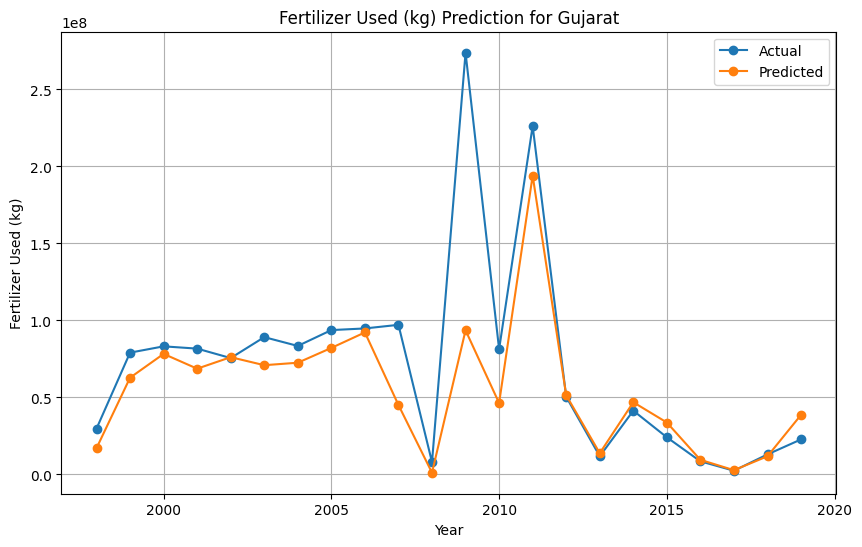

In [ ]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Choose what to predict: "Fertilizer Used (kg)" or "Pesticide Used (kg)"
target_variable = "Fertilizer Used (kg)"  # or switch to "Pesticide Used (kg)"

# 1. Find top 10 states by average yield
top_states = df.groupby("State")["Yield (tonnes/ha)"].mean().nlargest(10).index.tolist()

all_results = []

for state in top_states:
    df_state = df[df["State"] == state].sort_values("Crop_Year")

    for year in range(1998, 2020):
        train_df = df_state[df_state["Crop_Year"] < year]
        test_df = df_state[df_state["Crop_Year"] == year]

        if len(train_df) == 0 or len(test_df) == 0:
            continue

        features = ["Annual_Rainfall", "Yield (tonnes/ha)", "Pesticide Used (kg)"] if target_variable == "Fertilizer Used (kg)" \
                   else ["Annual_Rainfall", "Yield (tonnes/ha)", "Fertilizer Used (kg)"]
        target = target_variable

        X_train = train_df[features]
        y_train = train_df[target]
        X_test = test_df[features]
        y_test = test_df[target]

        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_results.append({
            "State": state,
            "Year": year,
            "Actual": y_test.values[0],
            "Predicted": y_pred[0],
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": sqrt(mean_squared_error(y_test, y_pred))
        })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Plot one example state
example_state = top_states[0]
df_plot = results_df[results_df["State"] == example_state]

plt.figure(figsize=(10, 6))
plt.plot(df_plot["Year"], df_plot["Actual"], marker='o', label="Actual")
plt.plot(df_plot["Year"], df_plot["Predicted"], marker='o', label="Predicted")
plt.title(f"{target_variable} Prediction for {example_state}")
plt.xlabel("Year")
plt.ylabel(target_variable)
plt.legend()
plt.grid(True)
plt.show()


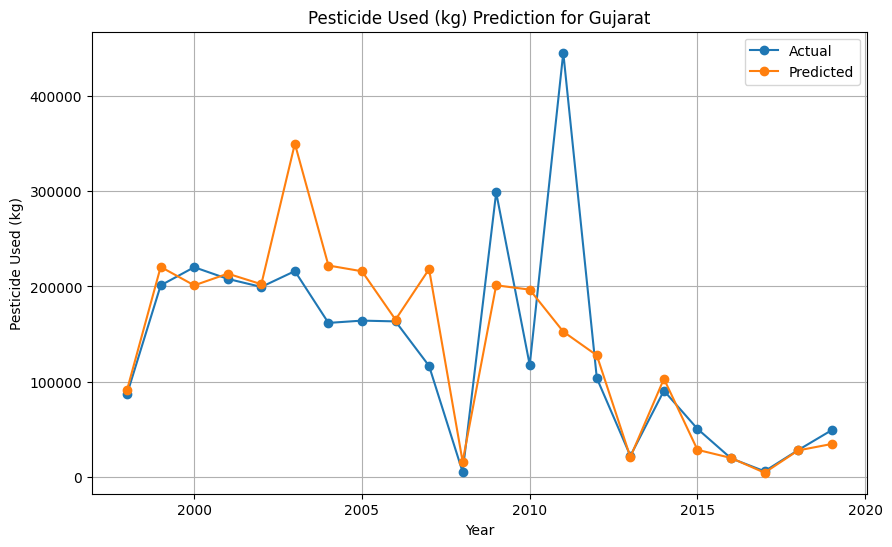

In [ ]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Choose what to predict: "Fertilizer Used (kg)" or "Pesticide Used (kg)"
target_variable = "Pesticide Used (kg)"  # or switch to "Pesticide Used (kg)"

# 1. Find top 10 states by average yield
top_states = df.groupby("State")["Yield (tonnes/ha)"].mean().nlargest(10).index.tolist()

all_results = []

for state in top_states:
    df_state = df[df["State"] == state].sort_values("Crop_Year")

    for year in range(1998, 2020):
        train_df = df_state[df_state["Crop_Year"] < year]
        test_df = df_state[df_state["Crop_Year"] == year]

        if len(train_df) == 0 or len(test_df) == 0:
            continue

        features = ["Annual_Rainfall", "Yield (tonnes/ha)", "Pesticide Used (kg)"] if target_variable == "Fertilizer Used (kg)" \
                   else ["Annual_Rainfall", "Yield (tonnes/ha)", "Fertilizer Used (kg)"]
        target = target_variable

        X_train = train_df[features]
        y_train = train_df[target]
        X_test = test_df[features]
        y_test = test_df[target]

        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_results.append({
            "State": state,
            "Year": year,
            "Actual": y_test.values[0],
            "Predicted": y_pred[0],
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": sqrt(mean_squared_error(y_test, y_pred))
        })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Plot one example state
example_state = top_states[0]
df_plot = results_df[results_df["State"] == example_state]

plt.figure(figsize=(10, 6))
plt.plot(df_plot["Year"], df_plot["Actual"], marker='o', label="Actual")
plt.plot(df_plot["Year"], df_plot["Predicted"], marker='o', label="Predicted")
plt.title(f"{target_variable} Prediction for {example_state}")
plt.xlabel("Year")
plt.ylabel(target_variable)
plt.legend()
plt.grid(True)
plt.show()

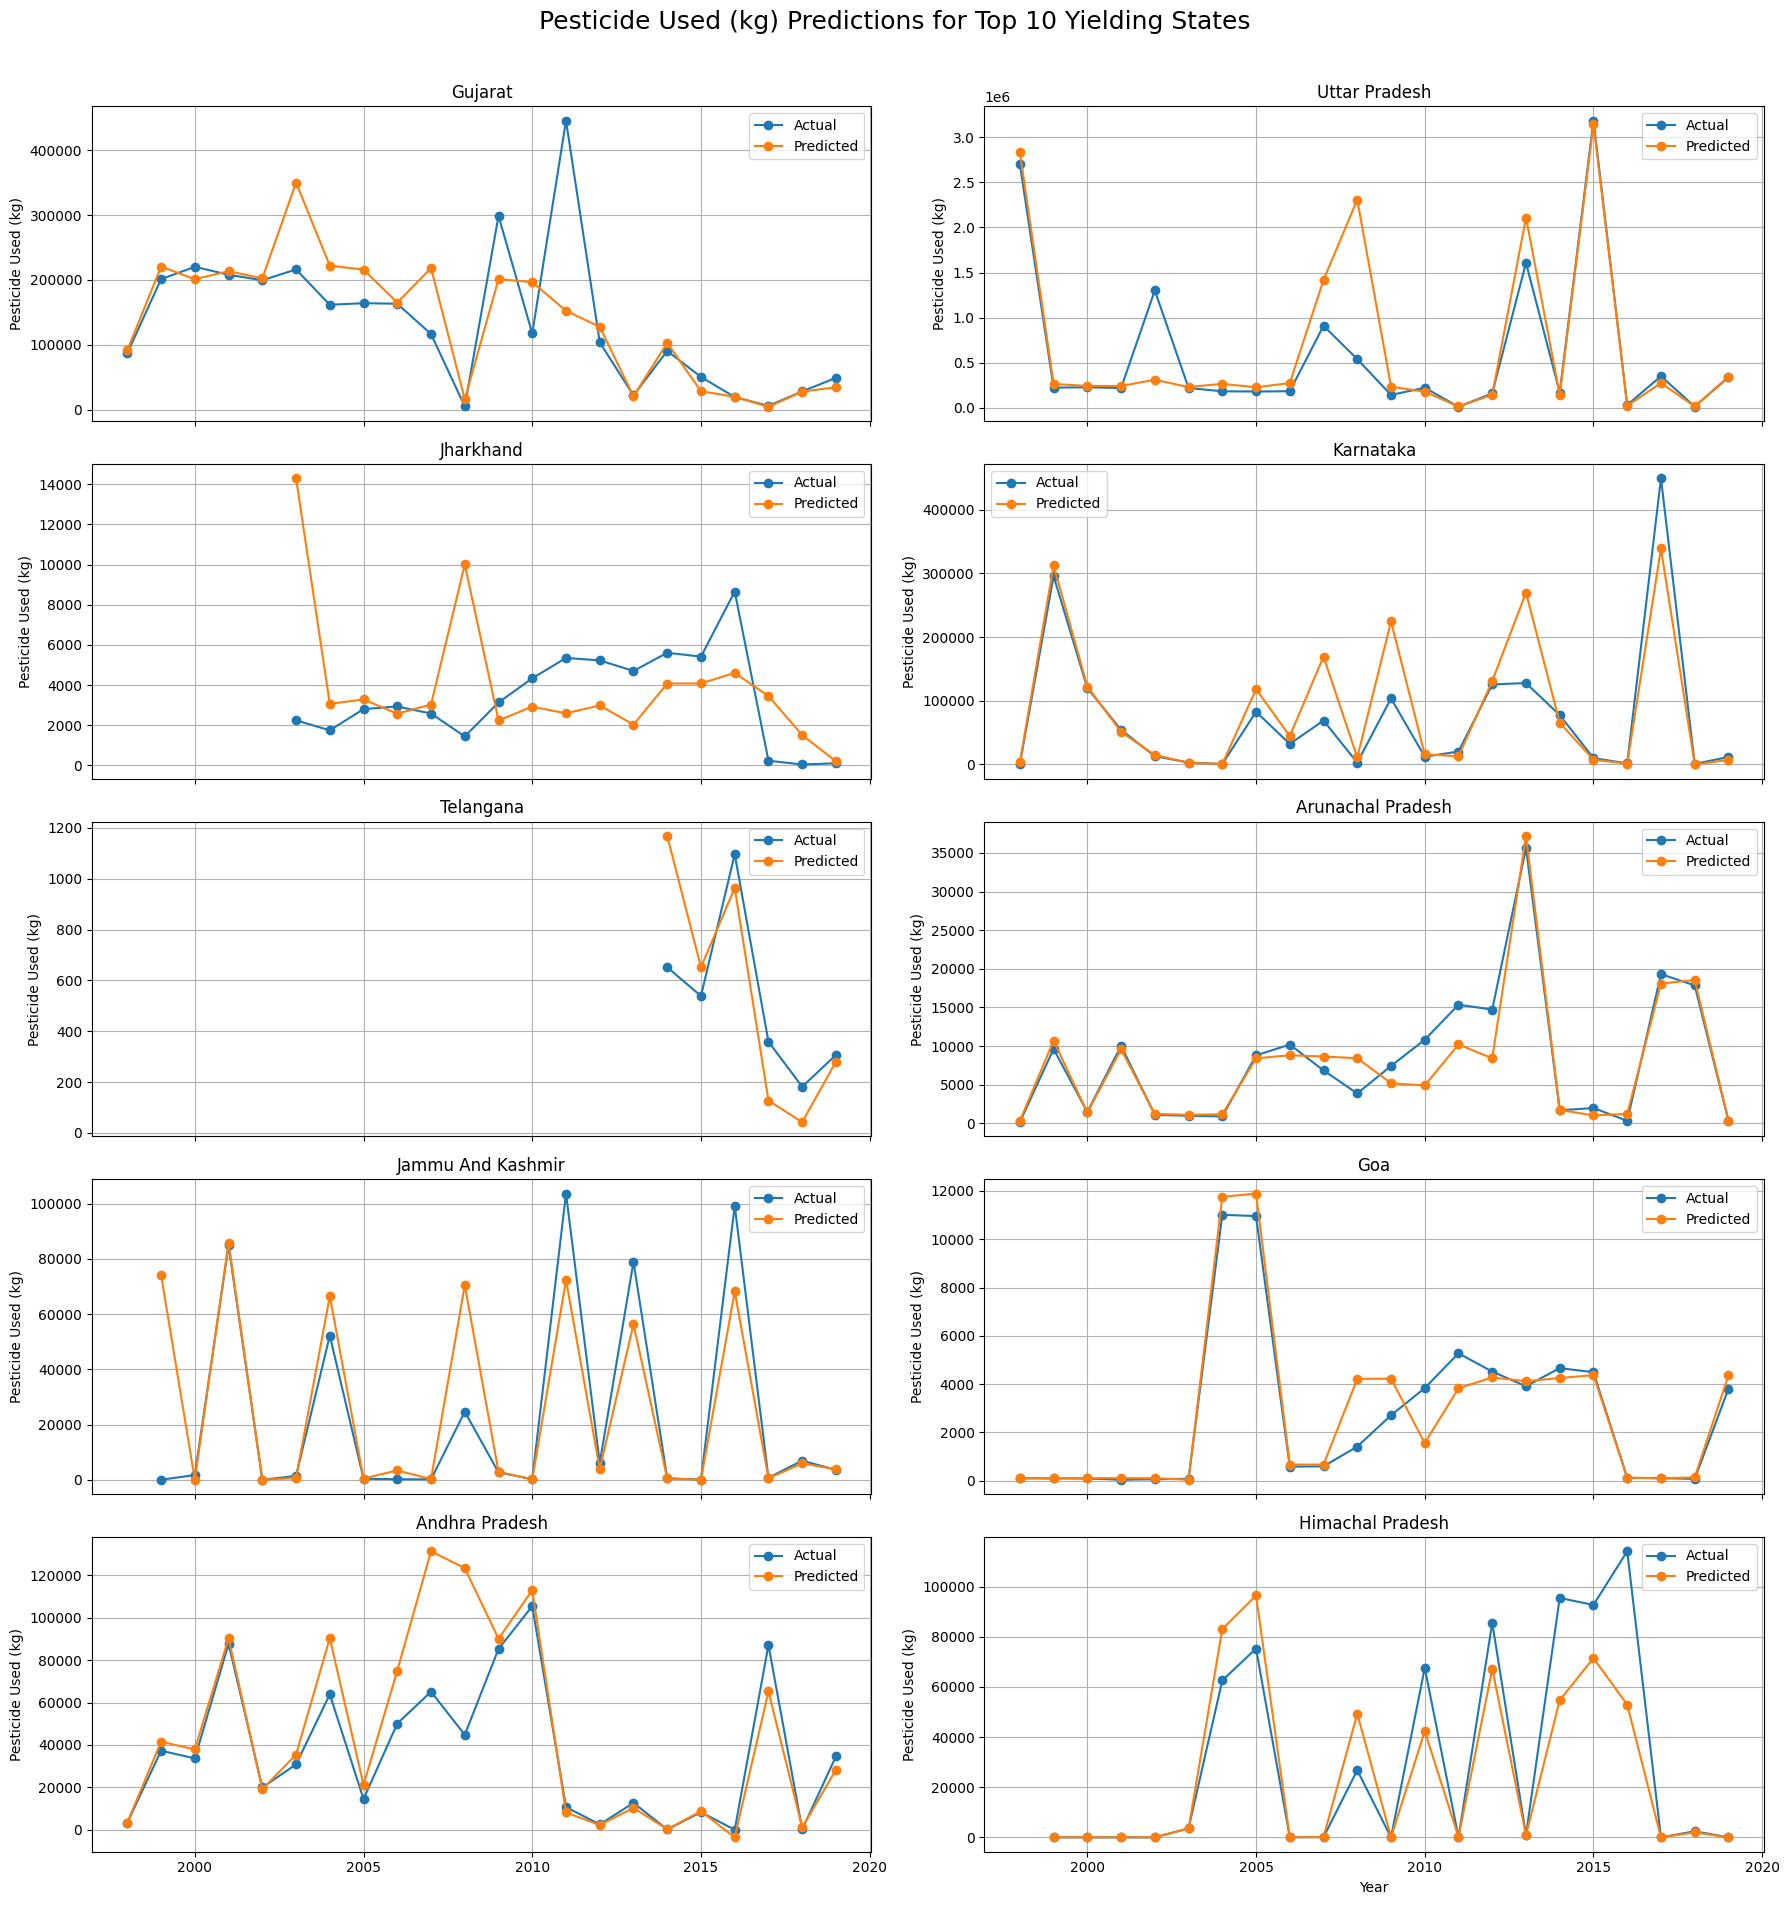

In [ ]:
# Plot predictions for all 10 states in subplots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
axes = axes.flatten()

for i, state in enumerate(top_states):
    df_plot = results_df[results_df["State"] == state]

    axes[i].plot(df_plot["Year"], df_plot["Actual"], marker='o', label="Actual")
    axes[i].plot(df_plot["Year"], df_plot["Predicted"], marker='o', label="Predicted")
    axes[i].set_title(f"{state}")
    axes[i].set_ylabel(target_variable)
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle(f"{target_variable} Predictions for Top 10 Yielding States", fontsize=18)
plt.xlabel("Year")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

target_variable = "Annual_Rainfall"

# Use the same top 10 yield states
rainfall_results = []

for state in top_states:
    df_state = df[df["State"] == state].sort_values("Crop_Year")

    for year in range(1998, 2020):
        train_df = df_state[df_state["Crop_Year"] < year]
        test_df = df_state[df_state["Crop_Year"] == year]

        if len(train_df) == 0 or len(test_df) == 0:
            continue

        features = ["Yield (tonnes/ha)", "Fertilizer Used (kg)", "Pesticide Used (kg)"]
        target = target_variable

        X_train = train_df[features]
        y_train = train_df[target]
        X_test = test_df[features]
        y_test = test_df[target]

        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rainfall_results.append({
            "State": state,
            "Year": year,
            "Actual": y_test.values[0],
            "Predicted": y_pred[0],
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": sqrt(mean_squared_error(y_test, y_pred))
        })

# Convert to DataFrame
rainfall_results_df = pd.DataFrame(rainfall_results)

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
axes = axes.flatten()

for i, state in enumerate(top_states):
    df_plot = rainfall_results_df[rainfall_results_df["State"] == state]

    axes[i].plot(df_plot["Year"], df_plot["Actual"], marker='o', label="Actual")
    axes[i].plot(df_plot["Year"], df_plot["Predicted"], marker='o', label="Predicted")
    axes[i].set_title(f"{state}")
    axes[i].set_ylabel("Rainfall (mm)")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Annual Rainfall Predictions for Top 10 Yielding States", fontsize=18)
plt.xlabel("Year")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()